In [1]:
import numpy as np
from scipy.sparse.linalg import cg
from scipy.sparse import csr_matrix
import numpy as np
import json
import hashlib
import threading
from puzzle_generation.tlp_lattice import generate_puzzle, solve_puzzle

In [104]:
T = 3**9  # Use small T for demonstration; large T will increase delay
message = b"This is a secret msg for HHL!"

print("[*] Generating puzzle...")
puzzle = generate_puzzle(T, message)
with open("./puzzle_generation/puzzle.json", "w") as f:
    json.dump(puzzle, f)

print("[*] Puzzle generated and saved to 'puzzle.json'.")
print("    Ciphertext:", puzzle['ciphertext'])

print("[*] Solving puzzle...")
with open("./puzzle_generation/puzzle.json", "r") as f:
    loaded_puzzle = json.load(f)

recovered = solve_puzzle(loaded_puzzle)
print("    Recovered Message:", recovered.decode())

[*] Generating puzzle...
[*] Puzzle generated and saved to 'puzzle.json'.
    Ciphertext: 07323acaed6d44d1f4c1778a50268e5a5680bbc504b0ea28297312fe94
[*] Solving puzzle...
[*] Puzzle generated and saved to 'puzzle.json'.
    Ciphertext: 07323acaed6d44d1f4c1778a50268e5a5680bbc504b0ea28297312fe94
[*] Solving puzzle...
    Recovered Message: This is a secret msg for HHL!
    Recovered Message: This is a secret msg for HHL!


## CGM

Complexity: $$ O(Nsk \log{(\frac{1}{\epsilon})}) $$

s = Sparsity, k = Condition number (ratio of largest to smalelst eigenvalue), N = size of matrix (NxN) 

- For CGM, if the matrix is not symmetric, it most likely won't converge to a value

In [81]:
A_matrix = np.random.rand(8192, 8192)

# for making it sparse
# mask = np.random.rand(8192, 8192) < 0.1
# A_matrix = A_matrix * mask


A_matrix = A_matrix + A_matrix.T # Make it symmetric for better conditioning
b_vector = np.random.rand(8192, 1)


In [82]:

# A_csr = csr_matrix(A_matrix)
x, exit_code = cg(A_matrix, b_vector)
# print("Condition:", np.linalg.cond(A_matrix))
# eigvals = np.linalg.eigvals(A_matrix)
# print("sparsity of Matrix A:", 1 - np.count_nonzero(A_matrix) / A_matrix.size)
x

array([-10.99441945,   5.18252855,   2.82510462, ...,   5.42516431,
        -0.02934705,  -8.24966421], shape=(8192,))

In [80]:
print("Condition:", np.linalg.cond(A_matrix))
print("sparsity of Matrix A:",  np.count_nonzero(A_matrix) / A_matrix.size)
eigvals = np.linalg.eigvals(A_matrix)
print(eigvals)


Condition: 204688.54123948587
sparsity of Matrix A: 0.18980783224105835
[409.636189    31.80155601  31.73022804 ...   0.46365104  -1.58159143
   1.18323225]
[409.636189    31.80155601  31.73022804 ...   0.46365104  -1.58159143
   1.18323225]


## CGM Performance Experiment
Measuring execution time for different matrix sizes N = 4, 8, 16, 32, ..., 4096

In [ ]:
import time
import matplotlib.pyplot as plt

# Matrix sizes: powers of 2 from 4 to 4096
matrix_sizes = [2**i for i in range(2, 13)]  # 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096
num_trials = 10

# Store average times
average_times = []

print("Running CGM experiments...")
print(f"{'N':<10} {'Avg Time (s)':<15} {'Status'}")
print("-" * 40)

for N in matrix_sizes:
    trial_times = []
    
    for trial in range(num_trials):
        # Generate random symmetric matrix and vector
        A_matrix = np.random.rand(N, N)
        A_matrix = A_matrix + A_matrix.T  # Make symmetric
        b_vector = np.random.rand(N)
        
        # Measure CGM execution time
        start_time = time.time()
        x, exit_code = cg(A_matrix, b_vector)
        end_time = time.time()
        
        trial_times.append(end_time - start_time)
    
    # Calculate average time for this matrix size
    avg_time = np.mean(trial_times)
    average_times.append(avg_time)
    
    print(f"{N:<10} {avg_time:<15.6f} {'✓' if exit_code == 0 else 'Warning'}")

print("\nExperiment completed!")

Running CGM experiments...
N          Avg Time (s)    Status
----------------------------------------
4          0.000045        ✓
8          0.000048        ✓
16         0.000087        ✓
32         0.000184        ✓
64         0.000441        ✓
128        0.001396        ✓
256        0.003971        ✓
512        0.013819        ✓
1024       0.073235        ✓
2048       1.427355        ✓
4096       11.611904       Warning

Experiment completed!


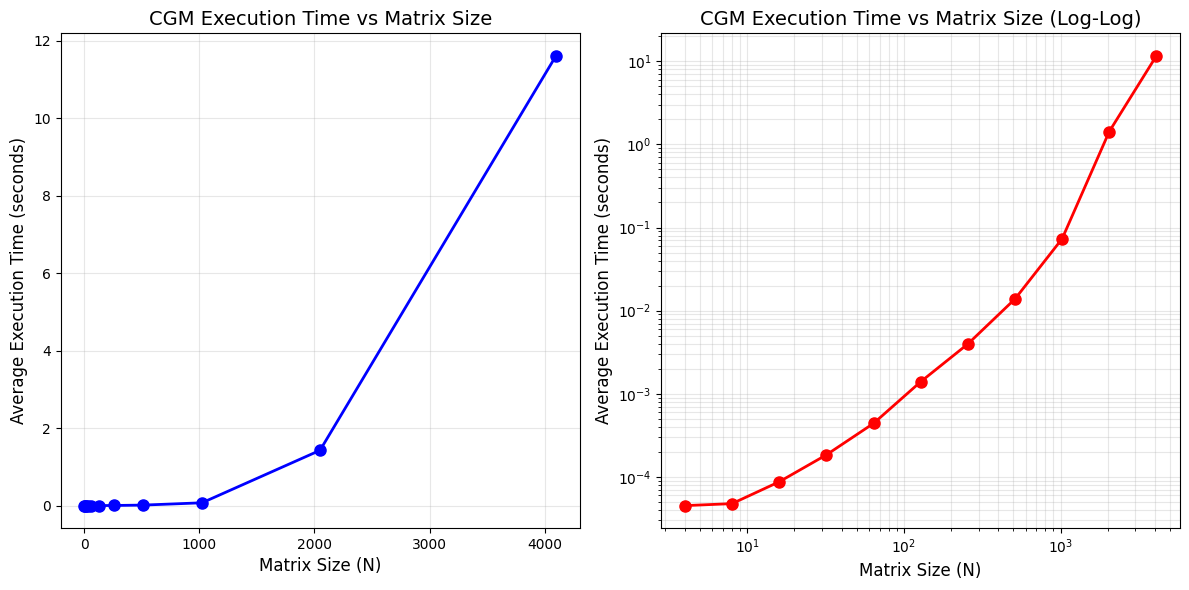


Summary Statistics:
Smallest N: 4, Time: 0.000045s
Largest N: 4096, Time: 11.611904s
Speedup factor: 257012.42x slower


In [ ]:
# Plot Time vs N
plt.figure(figsize=(12, 6))

# Linear scale plot
plt.subplot(1, 2, 1)
plt.plot(matrix_sizes, average_times, 'o-', linewidth=2, markersize=8, color='blue')
plt.xlabel('Matrix Size (N)', fontsize=12)
plt.ylabel('Average Execution Time (seconds)', fontsize=12)
plt.title('CGM Execution Time vs Matrix Size', fontsize=14)
plt.grid(True, alpha=0.3)

# Log-log scale plot
plt.subplot(1, 2, 2)
plt.loglog(matrix_sizes, average_times, 'o-', linewidth=2, markersize=8, color='red')
plt.xlabel('Matrix Size (N)', fontsize=12)
plt.ylabel('Average Execution Time (seconds)', fontsize=12)
plt.title('CGM Execution Time vs Matrix Size (Log-Log)', fontsize=14)
plt.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()
